# Keras deep learning library

## Load data

Import the required modules.

In [1]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
%matplotlib inline

Using TensorFlow backend.


Load the training data using scikit-learn under the hood.

In [2]:
data = np.genfromtxt('Data/otto_group_train.csv', delimiter=',',
                     skip_header=1, dtype=np.object)

For good measure, we shuffle the training data randomly.

In [3]:
np.random.shuffle(data)

The first column is an ID that doesn't concern us. The next 93 columns encode the features, which will be the input to the neural network, the last column is the label, the output of the network.

In [4]:
features = data[:, 1:-1].astype(dtype=np.float32)
labels = data[:, -1]

In [5]:
features.shape, features.dtype, labels.shape, labels.dtype

((61878, 93), dtype('float32'), (61878,), dtype('O'))

The labels should be encoded as one-hot.

In [6]:
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)
labels = np_utils.to_categorical(labels).astype(np.int32)

In [7]:
labels.shape, labels.dtype

((61878, 9), dtype('int32'))

We split the data into a training and a test set, selecting $10 \%$ for tests.

In [8]:
features_train, features_test, Y_train, Y_test = train_test_split(features, labels,
                                                                  test_size=0.10,
                                                                  random_state=42)

We rescale the features we'll use for training.

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)

The test features are transformed using the fitted scaler for the training features.

In [10]:
X_test = scaler.transform(features_test)

In [11]:
X_train.shape, Y_train.shape

((55690, 93), (55690, 9))

In [12]:
X_test.shape, Y_test.shape

((6188, 93), (6188, 9))

In [13]:
nr_features, nr_classes = X_train.shape[1], Y_train.shape[1]

## Defining a simple network

Import the required modules.

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Define the neural network as sequential, i.e., a layered network. It has a single layer that has the features as input, and the classes as output with a sigmoid activation function.

The activation for the final output is set to softmax.

In [25]:
model = Sequential()
model.add(Dense(nr_classes, input_shape=(nr_features,), activation='sigmoid'))
model.add(Activation('softmax'))

Compile the model, setting the optimization strategy, and the loss function.

In [26]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 9)                 846       
_________________________________________________________________
activation_2 (Activation)    (None, 9)                 0         
Total params: 846
Trainable params: 846
Non-trainable params: 0
_________________________________________________________________


The number of parameters in the single layer is $93 \times 9 + 9 = 846$, i.e., the number of features multiplied by the number of classes, plus $9$ bias units.

## Training the network

Train the network on the training data.

In [28]:
history = model.fit(X_train, Y_train)

Epoch 1/10
55690/55690 [==============================] - 9s - loss: 2.0123 - acc: 0.4316     
Epoch 2/10
55690/55690 [==============================] - 8s - loss: 1.8559 - acc: 0.6294     
Epoch 3/10
55690/55690 [==============================] - 11s - loss: 1.7982 - acc: 0.6697    
Epoch 4/10
55690/55690 [==============================] - 12s - loss: 1.7616 - acc: 0.6877    
Epoch 5/10
55690/55690 [==============================] - 13s - loss: 1.7353 - acc: 0.6987    
Epoch 6/10
55690/55690 [==============================] - 18s - loss: 1.7152 - acc: 0.7049    
Epoch 7/10
55690/55690 [==============================] - 30s - loss: 1.6994 - acc: 0.7087    
Epoch 8/10
55690/55690 [==============================] - 15s - loss: 1.6865 - acc: 0.7116    
Epoch 9/10
55690/55690 [==============================] - 14s - loss: 1.6759 - acc: 0.7136    
Epoch 10/10
55690/55690 [==============================] - 17s - loss: 1.6670 - acc: 0.7149    - ETA: 1s - los


In [29]:
model.evaluate(X_test, Y_test)

5984/6188 [============================>.] - ETA: 0s

[1.6596782705286046, 0.71881060120207152]

In [56]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    if 'val_loss' in network_history.history:
        plt.plot(network_history.history['val_loss'])
        plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    if 'val_acc' in network_history.history:
        plt.plot(network_history.history['val_acc'])
        plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

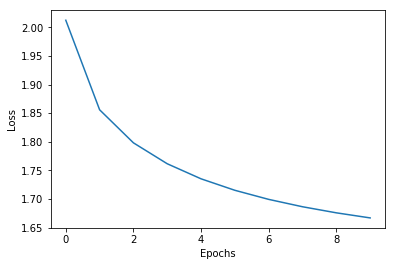

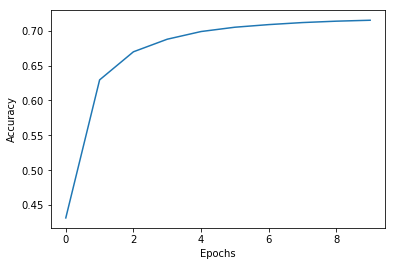

In [35]:
plot_history(history)

## Training using validation

Split the training set into a part used for training, and another for validation to reduce the risk of overfitting, using $15 \%$ for validation.  The random state is set explicitely for reproducability.

In [36]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size=0.15,
                                                  random_state=42)

We want to save the best model to an HDF5 file so that it can be reloaded, and we want to use early stopping based on the changes of the loss function.  First, import the required  class definitions

In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [40]:
model_filename = 'best_model.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
check_point = ModelCheckpoint(model_filename, save_best_only=True, verbose=1)

In [41]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50,
                    batch_size=128, verbose=1,
                    callbacks=[check_point, early_stopping])

Train on 47336 samples, validate on 8354 samples
Epoch 1/50
47336/47336 [==============================] - 3s - loss: 1.6223 - acc: 0.7206 - val_loss: 1.6242 - val_acc: 0.7303
Epoch 2/50
47336/47336 [==============================] - 3s - loss: 1.6218 - acc: 0.7207 - val_loss: 1.6236 - val_acc: 0.7305
Epoch 3/50
47336/47336 [==============================] - 3s - loss: 1.6213 - acc: 0.7207 - val_loss: 1.6231 - val_acc: 0.7307
Epoch 4/50
47336/47336 [==============================] - 3s - loss: 1.6207 - acc: 0.7207 - val_loss: 1.6226 - val_acc: 0.7308
Epoch 5/50
47336/47336 [==============================] - 3s - loss: 1.6202 - acc: 0.7208 - val_loss: 1.6221 - val_acc: 0.7308
Epoch 6/50
47336/47336 [==============================] - 3s - loss: 1.6197 - acc: 0.7209 - val_loss: 1.6216 - val_acc: 0.7308
Epoch 7/50
47336/47336 [==============================] - 3s - loss: 1.6192 - acc: 0.7210 - val_loss: 1.6211 - val_acc: 0.7309
Epoch 8/50
47336/47336 [==============================] - 3s -

47336/47336 [==============================] - 3s - loss: 1.6105 - acc: 0.7224 - val_loss: 1.6124 - val_acc: 0.7327
Epoch 29/50
47336/47336 [==============================] - 2s - loss: 1.6102 - acc: 0.7226 - val_loss: 1.6121 - val_acc: 0.7328
Epoch 30/50
47336/47336 [==============================] - 3s - loss: 1.6098 - acc: 0.7226 - val_loss: 1.6118 - val_acc: 0.7328
Epoch 31/50
47336/47336 [==============================] - 2s - loss: 1.6095 - acc: 0.7227 - val_loss: 1.6114 - val_acc: 0.7327
Epoch 32/50
47336/47336 [==============================] - 2s - loss: 1.6092 - acc: 0.7227 - val_loss: 1.6111 - val_acc: 0.7326
Epoch 33/50
47336/47336 [==============================] - 2s - loss: 1.6088 - acc: 0.7227 - val_loss: 1.6108 - val_acc: 0.7327
Epoch 34/50
47336/47336 [==============================] - 2s - loss: 1.6085 - acc: 0.7228 - val_loss: 1.6104 - val_acc: 0.7328
Epoch 35/50
47336/47336 [==============================] - 3s - loss: 1.6082 - acc: 0.7228 - val_loss: 1.6101 - val_

In [42]:
model.evaluate(X_train, Y_train)

47232/47336 [============================>.] - ETA: 0s

[1.6037227596728125, 0.72395217170863613]

In [43]:
model.evaluate(X_test, Y_test)

6080/6188 [============================>.] - ETA: 0s

[1.5994650452231005, 0.73109243701331905]

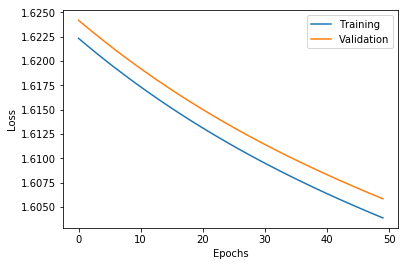

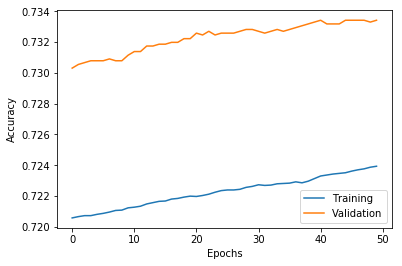

In [46]:
plot_history(history)

## Multilayer network

In [47]:
nr_hidden = 20
model = Sequential()
model.add(Dense(nr_hidden, input_shape=(nr_features,), activation='relu'))
model.add(Dense(nr_classes, input_shape=(nr_hidden,), activation='relu'))
model.add(Activation('softmax'))

Compile the model, setting the optimization strategy, and the loss function.

In [48]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                1880      
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 189       
_________________________________________________________________
activation_3 (Activation)    (None, 9)                 0         
Total params: 2,069
Trainable params: 2,069
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_filename = 'best_model.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
check_point = ModelCheckpoint(model_filename, save_best_only=True, verbose=1)

In [51]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    epochs=50, batch_size=128, verbose=1,
                    callbacks=[check_point, early_stopping])

Train on 47336 samples, validate on 8354 samples
Epoch 1/50
47336/47336 [==============================] - 4s - loss: 1.9058 - acc: 0.3796 - val_loss: 1.6082 - val_acc: 0.5083
Epoch 2/50
47336/47336 [==============================] - 3s - loss: 1.4470 - acc: 0.5418 - val_loss: 1.3187 - val_acc: 0.5773
Epoch 3/50
47336/47336 [==============================] - 3s - loss: 1.2005 - acc: 0.6186 - val_loss: 1.1102 - val_acc: 0.6554
Epoch 4/50
47336/47336 [==============================] - 4s - loss: 1.0435 - acc: 0.6599 - val_loss: 1.0051 - val_acc: 0.6732
Epoch 5/50
47336/47336 [==============================] - 4s - loss: 0.9656 - acc: 0.6727 - val_loss: 0.9507 - val_acc: 0.6804
Epoch 6/50
47336/47336 [==============================] - 3s - loss: 0.9209 - acc: 0.6812 - val_loss: 0.9159 - val_acc: 0.6861
Epoch 7/50
47336/47336 [==============================] - 5s - loss: 0.8902 - acc: 0.6875 - val_loss: 0.8899 - val_acc: 0.6913
Epoch 8/50
47336/47336 [==============================] - 4s -

47336/47336 [==============================] - 2s - loss: 0.6359 - acc: 0.7613 - val_loss: 0.6558 - val_acc: 0.7629
Epoch 29/50
47336/47336 [==============================] - 2s - loss: 0.6326 - acc: 0.7623 - val_loss: 0.6533 - val_acc: 0.7621
Epoch 30/50
47336/47336 [==============================] - 3s - loss: 0.6297 - acc: 0.7633 - val_loss: 0.6504 - val_acc: 0.7635
Epoch 31/50
47336/47336 [==============================] - 2s - loss: 0.6269 - acc: 0.7638 - val_loss: 0.6484 - val_acc: 0.7625
Epoch 32/50
47336/47336 [==============================] - 2s - loss: 0.6243 - acc: 0.7640 - val_loss: 0.6463 - val_acc: 0.7639
Epoch 33/50
47336/47336 [==============================] - 2s - loss: 0.6219 - acc: 0.7648 - val_loss: 0.6442 - val_acc: 0.7637
Epoch 34/50
47336/47336 [==============================] - 2s - loss: 0.6197 - acc: 0.7655 - val_loss: 0.6423 - val_acc: 0.7651
Epoch 35/50
47336/47336 [==============================] - 2s - loss: 0.6175 - acc: 0.7657 - val_loss: 0.6405 - val_

In [52]:
model.evaluate(X_test, Y_test)

6144/6188 [============================>.] - ETA: 0s

[0.59830185571599948, 0.76971557853910799]

Plot the training history.

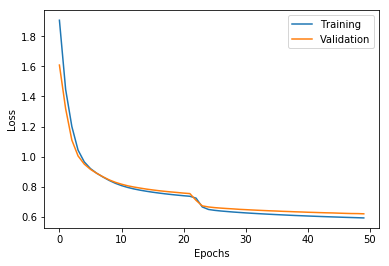

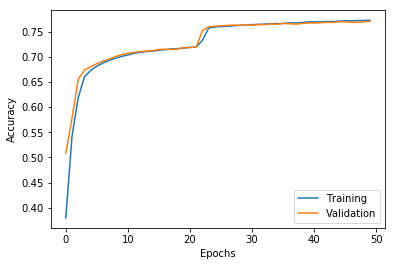

In [57]:
plot_history(history)